- Importamos librerías:

In [1]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt 
import pygame

- Creamos el entorno y visualizamos los valores de los límites inferiores y superiores del entorno:

In [2]:
env = gym.make("MountainCar-v0")

In [3]:
print("Límites superiores:", env.observation_space.high)	
print("Límites inferiores:", env.observation_space.low)	
print("Número de acciones disponibles:", env.action_space.n)      

Límites superiores: [0.6  0.07]
Límites inferiores: [-1.2  -0.07]
Número de acciones disponibles: 3


# ALGORITMO SARSA

- Definimos los hiperparámetros:

In [13]:
discrete_buckets = 20 # nº de cubos en los que se dividirá el espacio de observación
episodes = 1000
discount = 0.95 #peso a las recompensas futuras en relación con las inmediatas
                #se devalúan en un 5% en cada paso de tiempo
episode_display = 10
learning_rate = 0.1
epsilon = 0.5 #misma probabilidad de que el agente elija una acción aleatoria o 
              #la mejor acción según la tabla Q
epsilon_decrementer = epsilon/(episodes//4) #el valor de epsilon se reducira a la mitad
            #aprox. después de que el agente haya completado aproximadamente la mitad 
            #de los episodios

In [14]:
#Creación de la tabla Q
q_table = np.random.randn(discrete_buckets,discrete_buckets,env.action_space.n)

# Lista para almacenar las recompensas
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

In [15]:
def discretised_state(state):
    discrete_win_size = (env.observation_space.high - env.observation_space.low) / [discrete_buckets] * len(env.observation_space.high)
    discrete_state = (state - env.observation_space.low) // discrete_win_size
    return tuple(discrete_state.astype(int))		

for episode in range(episodes):
    episode_reward = 0  # rastrea recompensa total obtenida en cada episodio
    done = False

    if episode % episode_display == 0:
        render_state = True  # para mostrar o no el estado del entorno
    else:
        render_state = False
    state_array = env.reset()[0]

    curr_discrete_state = discretised_state(state_array)  # asigna a la variable el estado inicial del 
                                                         # entorno discretizado
    # a continuación, si el número aleatorio generado es mayor que epsilon,
    # el agente seleccionará la acción con el valor más alto de Q,
    # si no, seleccionará una acción aleatoria:
    if np.random.random() > epsilon:
        action = np.argmax(q_table[curr_discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)

    while not done:        
        new_state, reward, done, _, _ = env.step(action)
        new_discrete_state = discretised_state(new_state)  # se discretiza para obtener el nuevo estado del entorno

        if np.random.random() > epsilon:
            new_action = np.argmax(q_table[new_discrete_state])
        else:
            new_action = np.random.randint(0, env.action_space.n)

        if render_state:
            env.render()

        if not done:
            current_q = q_table[curr_discrete_state + (action,)]  # valor Q actual asociado con el
                                                                  # par estado-acción actual        
            max_future_q = q_table[new_discrete_state + (new_action,)]  # obtiene valor Q máximo esperado
                                                                       # para los próximos estado y acción
            new_q = current_q + learning_rate * (reward + discount * max_future_q - current_q)  # calcula el nuevo valor Q
                                                                                                  # para el par estado-acción actual
            q_table[curr_discrete_state + (action,)] = new_q
        elif new_state[0] >= env.goal_position:
            q_table[curr_discrete_state + (action,)] = 0

        curr_discrete_state = new_discrete_state
        action = new_action

        episode_reward += reward

    epsilon = epsilon - epsilon_decrementer

    ep_rewards.append(episode_reward)

    if not episode % episode_display:
        avg_reward = sum(ep_rewards[-episode_display:]) / len(ep_rewards[-episode_display:])
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-episode_display:]))
        ep_rewards_table['max'].append(max(ep_rewards[-episode_display:]))
        
        print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-episode_display:])} max:{max(ep_rewards[-episode_display:])}")

env.close()


Episode:0 avg:-8644.0 min:-8644.0 max:-8644.0
Episode:10 avg:-1635.3 min:-3896.0 max:-584.0
Episode:20 avg:-938.6 min:-1534.0 max:-499.0
Episode:30 avg:-1226.9 min:-3315.0 max:-378.0
Episode:40 avg:-901.1 min:-2049.0 max:-450.0
Episode:50 avg:-438.6 min:-664.0 max:-314.0
Episode:60 avg:-394.8 min:-642.0 max:-252.0
Episode:70 avg:-412.7 min:-826.0 max:-196.0
Episode:80 avg:-320.6 min:-421.0 max:-239.0
Episode:90 avg:-483.2 min:-1019.0 max:-250.0
Episode:100 avg:-461.2 min:-1296.0 max:-165.0
Episode:110 avg:-457.0 min:-967.0 max:-255.0
Episode:120 avg:-332.7 min:-713.0 max:-185.0
Episode:130 avg:-370.1 min:-725.0 max:-158.0
Episode:140 avg:-580.2 min:-2142.0 max:-242.0
Episode:150 avg:-971.3 min:-3108.0 max:-170.0
Episode:160 avg:-477.5 min:-1731.0 max:-188.0
Episode:170 avg:-292.2 min:-410.0 max:-156.0
Episode:180 avg:-288.5 min:-436.0 max:-179.0
Episode:190 avg:-234.2 min:-412.0 max:-150.0
Episode:200 avg:-325.8 min:-665.0 max:-155.0
Episode:210 avg:-299.1 min:-613.0 max:-178.0
Episode

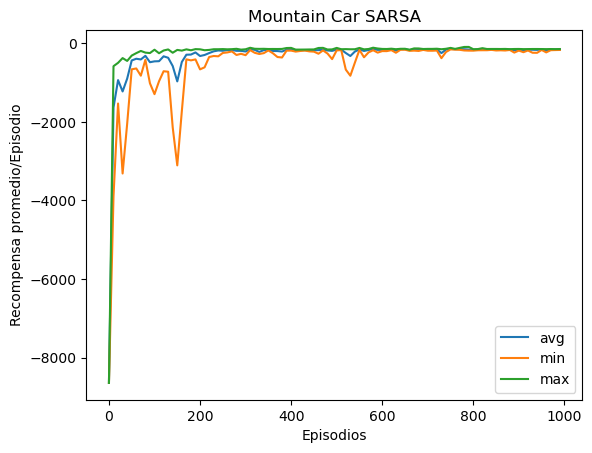

In [20]:
#Representamos recompensas:
plt.plot(ep_rewards_table['ep'], ep_rewards_table['avg'], label="avg")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['min'], label="min")
plt.plot(ep_rewards_table['ep'], ep_rewards_table['max'], label="max")
plt.legend(loc=4) #bottom right
plt.title('Mountain Car SARSA')
plt.ylabel('Recompensa promedio/Episodio')
plt.xlabel('Episodios')
plt.show()

## Métricas

**1. Media móvil** <p>
Ya que las recompensas pueden variar mucho de un episodio a otro, calcularemos la media móvil. Esto significa calcular el promedio de recompensas de x número de episodios consecutivos y así ver mejor si realmente el agente ha mejorado. Vamos a coger una ventana de 100 episodios y así ver si recientemente ha habido mejoría.

In [17]:
window_size1 = 100
moving_avg_rewards1 = np.convolve(ep_rewards, np.ones(window_size1)/window_size1, mode='valid')

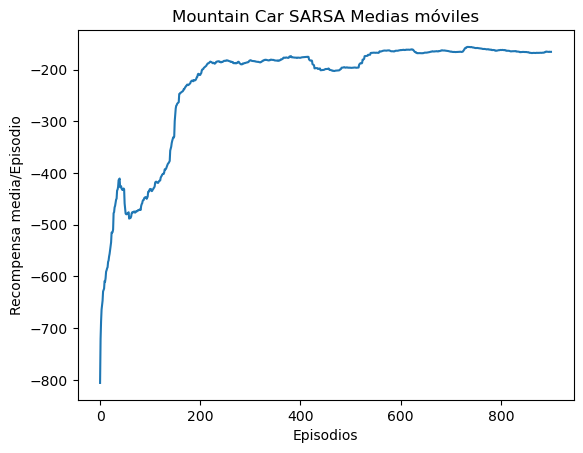

In [18]:
plt.plot(np.arange(len(moving_avg_rewards1)), moving_avg_rewards1)
plt.title('Mountain Car SARSA Medias móviles')
plt.ylabel('Recompensa media/Episodio')
plt.xlabel('Episodios')
plt.show()

**2. Tasa de convergencia** <p>
Representa la diferencia entre la recompensa promedio al final del entrenamiento y al principio entre el número total de episodios. Esto sirve para descubrir qué tan rápido está mejorando el desempeño del agente a lo largo del tiempo. 

In [19]:
convergence_rate1 = (ep_rewards_table['avg'][-1] - ep_rewards_table['avg'][0]) / len(ep_rewards_table['avg'])
print("Convergence Rate:", convergence_rate1)

Convergence Rate: 84.86399999999999
